# Preparing a model for the Titanic dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

## Load the data split it to train and test

In [2]:
from sklearn.model_selection import train_test_split

df= pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv')
X= df.drop(['Survived'], axis= 1)
y= df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X-train dimensions: {X_train.shape}")
print(f"y-train dimensions: {y_train.shape}")
print('\n','='*50, '\n')
print(f"X-test dimensions: {X_test.shape}")
print(f"y-test dimensions: {y_test.shape}")

X-train dimensions: (712, 11)
y-train dimensions: (712,)


X-test dimensions: (179, 11)
y-test dimensions: (179,)


In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          572 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        159 non-null    object 
 10  Embarked     710 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [4]:
#There are some missing values:
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            140
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         2
dtype: int64

In [5]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


# Preparing custom estimators 

In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import FunctionTransformer


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names_in_):
        self.feature_names_in_ = feature_names_in_
        self.n_features_in_ = len(feature_names_in_)  
    def fit( self, X, y = None ):
        return self
    def transform(self, X, y=None):
        return X.loc[:, self.feature_names_in_].copy(deep=True)

class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform(self, X, y=None):
        X.loc[:,'FamilySize']= X['SibSp'] + X['Parch']
        X.loc[:,'AgeClass'] = X['Pclass'] * X['Age']
        #X.loc[:,'FarePerPerson'] = X['Fare'] / (X['FamilySize'] + 1)
        #X.loc[:,'IsAlone'] = 1
        return X
        
#IsAloneInitializer and IsAloneAdder can be incorporated later
class IsAloneInitializer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform(self, X, y=None):
        X.loc[:,'IsAlone']= 1
        return X[['IsAlone']]

class IsAloneAdder(BaseEstimator, TransformerMixin):
  def AloneVsNot(row):
    if row["FamilySize"] > 1:
      row["IsAlone"] = 0
    return row
    X = X.apply(AloneVsNot, axis=1)
    return X
  
class FrequencyBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform(self, X, y=None):
        X.loc[:,'FareBin']= pd.qcut(df['Fare'], 4)
        X.loc[:,'AgeBin'] = pd.cut(df['Age'], 4)
        #X.loc[:,'FarePerPerson'] = X['Fare'] / (X['FamilySize'] + 1)
        #X.loc[:,'IsAlone'] = 1
        return X.loc[:,['FareBin', 'AgeBin']]



# Implementing the data-processing pipeline



In [7]:
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

#Construct FuntionTransformers for engineering the Name and Cabin columns:
TitleExtractor = FunctionTransformer(func= lambda x: x.str.extract(r'([^,]*\.)')) #replace names with titles, the regex extracts the first word after the comma up to the dot
cabin_extractor = FunctionTransformer(func= lambda x: x.str.extract(r"([A-Z])")) #Simplifying the Cabin column
nan_replacer = FunctionTransformer(func= lambda x: x.replace(np.nan,'N')) #replaces the NaN values with N

#Define columns to operate on:
int_cols= X_train.select_dtypes(include=['int64']).drop('PassengerId', axis= 1).columns.tolist()
float_cols= X_train.select_dtypes(include=['float64']).columns.tolist()
numerical_col= int_cols + float_cols
SimpleOneHot_col= X_train.select_dtypes(include=['object']).drop(['Name', 'Ticket', 'Cabin'], axis= 1).columns.tolist()
name= 'Name'
cabin= 'Cabin'
FareAge= ['Fare', 'Age']

#Prepare pipelines for corresponding columns:
numerical_pipeline = Pipeline(steps = [("num_selector", FeatureSelector(numerical_col)),
                                       ("imputer", SimpleImputer(strategy="median")),
                                       ("std_scaler", MinMaxScaler()) 
                                       ])

categorical_pipeline = Pipeline(steps = [("cat_selector", FeatureSelector(SimpleOneHot_col)),
                                         ("imputer", SimpleImputer(strategy="most_frequent")),
                                         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse= False))
                                         ])

name_pipeline= Pipeline(steps= [("name_selector", FeatureSelector(name)),
                                ('TitleExtractor', TitleExtractor),
                                ('impute', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse= False))
                                ])

cabin_pipeline= Pipeline(steps= [("cabin_selector", FeatureSelector(cabin)),
                                 ('nan_replacer', nan_replacer),
                                 ('cabin_extractor', cabin_extractor),
                                 ('impute', SimpleImputer(strategy='most_frequent')),
                                 ('onehot', OneHotEncoder(handle_unknown='ignore', sparse= False))
                                 ])

feature_adder_pipeline = Pipeline(steps = [("feature_adder_selector", FeatureSelector(["SibSp", "Parch", 'Pclass', 'Age'])),
                                           ("feature_engineering", FeatureAdder()),
                                           ("imputer", SimpleImputer(strategy="median")),
                                           ("std_scaler", MinMaxScaler()) 
                                  ])

FareAge_binner_pipeline= Pipeline(steps = [("FrequencyBinner", FrequencyBinner()),
                                           ('impute', SimpleImputer(strategy='most_frequent')),
                                           ('onehot', OneHotEncoder(handle_unknown='ignore', sparse= False))
                                           ])


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import FeatureUnion

#Put all the pipelines inside a FeatureUnion: 
data_preprocessing_pipeline = FeatureUnion(
    n_jobs=-1, 
    transformer_list=[
                      ("numerical_pipeline", numerical_pipeline),
                      ("categorical_pipeline", categorical_pipeline),
                      ("name_pipeline", name_pipeline),
                      ("cabin_pipeline", cabin_pipeline),
                      ("feature_adder_pipeline", feature_adder_pipeline),
                      ("FareAge_binner_pipeline", FareAge_binner_pipeline),
                      ])

#model_pipeline can be extended later with the addition of the selected model:
#for now it only functions as a data pre-processing pipeline
model_pipeline = Pipeline(steps=[
                                 ("data_preprocessing_pipeline", data_preprocessing_pipeline),
                                 #("model", GradientBoostingClassifier())
                                 ])
X_train_prepared= model_pipeline.fit_transform(X_train)

# Compare the performance of several ML algorithms

In [9]:
#Machine Learning Algorithm (MLA) Selection and Initialization
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, precision_score


MLA = [
    #Ensemble Methods
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    #HistGradientBoostingClassifier(),

    #Gaussian Processes
    GaussianProcessClassifier(),
    
    #GLM
    LogisticRegression(),
    PassiveAggressiveClassifier(),
    RidgeClassifier(),
    SGDClassifier(),
    Perceptron(),
    
    #Navies Bayes
    BernoulliNB(),
    GaussianNB(),
    
    #Nearest Neighbor
    KNeighborsClassifier(), #SVM
    SVC(probability=True),
    NuSVC(probability=True),
    #LinearSVC(),
    
    #Trees    
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    
    #Discriminant Analysis
    #LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier(),    
    
    DummyClassifier()
    ]

scorer= make_scorer(f1_score, greater_is_better=True)
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train f1 Mean', 'MLA Test f1 Mean', 'MLA Test f1 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = y_train

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = cross_validate(alg, X_train_prepared, y_train, cv  = cv_split, scoring= scorer, return_train_score= True)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train f1 Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test f1 Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test f1 3*STD'] = cv_results['test_score'].std()*3 
    
    alg.fit(X_train_prepared, y_train)
    #MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test f1 Mean'], ascending = False)

,MLA Name,MLA Parameters,MLA Train f1 Mean,MLA Test f1 Mean,MLA Test f1 3*STD,MLA Time
6,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.795742,0.751153,0.080911,0.020592
8,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.793273,0.748915,0.074701,0.003399
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.796032,0.741942,0.080962,0.05698
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.836974,0.730321,0.089823,0.159941
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.833366,0.719418,0.082293,0.104872
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.90531,0.718157,0.108248,0.143848
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.740824,0.709338,0.073512,0.001999
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.986214,0.709034,0.11159,0.181533
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.986164,0.707732,0.073852,0.148747
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.748424,0.704362,0.124472,0.072473


Out of all the classifiers the LogisticRegression seems to have performed the best.

## Tuning the LogisticRegression model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from scipy.stats import uniform
from scipy.stats import randint

full_pipeline = Pipeline([
                          ('model_pipeline', model_pipeline),
                          ('model', LogisticRegression())
                          ])

parameters = {
    'model__penalty' : ['l1', 'l2', 'none'],
    'model__C'    : uniform(0.01, 5),
    'model__solver'    : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    }

mod = RandomizedSearchCV(estimator=full_pipeline, 
                         param_distributions = parameters,
                         scoring= {'precision': make_scorer(precision_score), 
                                   'recall': make_scorer(recall_score),
                                   'f1': make_scorer(f1_score, greater_is_better=True)},
                         refit= 'f1',
                         cv = 10, 
                         n_iter = 10000, 
                         n_jobs=-1,
                         return_train_score= False)

mod.fit(X_train, y_train)
pd.DataFrame(mod.cv_results_)

C:\Users\CAdam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.78260692 0.78025018        nan ... 0.77429802 0.77429802 0.78260692]
  warnings.warn(
C:\Users\CAdam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.75       0.74245014        nan ... 0.73846154 0.73846154 0.75      ]
  warnings.warn(
C:\Users\CAdam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.76378968 0.75901202        nan ... 0.75439979 0.75439979 0.76378968]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,param_model__solver,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,split5_test_precision,split6_test_precision,split7_test_precision,split8_test_precision,split9_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,split5_test_recall,split6_test_recall,split7_test_recall,split8_test_recall,split9_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,split7_test_f1,split8_test_f1,split9_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.122664,0.014364,0.070386,0.004396,3.370196,l2,liblinear,"{'model__C': 3.3701959867834637, 'model__penal...",0.814815,0.653846,0.681818,0.888889,0.793103,0.782609,0.769231,0.857143,0.7,0.884615,0.782607,0.078832,1800,0.814815,0.62963,0.576923,0.923077,0.851852,0.666667,0.740741,0.666667,0.777778,0.851852,0.750000,0.106815,12,0.814815,0.641509,0.625,0.905660,0.821429,0.720000,0.754717,0.750000,0.736842,0.867925,0.763790,0.086040,889
1,1.802545,1.050149,0.072868,0.007630,4.546588,l2,lbfgs,"{'model__C': 4.546587772512451, 'model__penalt...",0.814815,0.653846,0.681818,0.884615,0.821429,0.782609,0.769231,0.809524,0.7,0.884615,0.780250,0.076004,3154,0.814815,0.62963,0.576923,0.884615,0.851852,0.666667,0.740741,0.629630,0.777778,0.851852,0.742450,0.104516,3137,0.814815,0.641509,0.625,0.884615,0.836364,0.720000,0.754717,0.708333,0.736842,0.867925,0.759012,0.085500,3284
2,0.114089,0.014387,0.000000,0.000000,2.876622,none,liblinear,"{'model__C': 2.8766217897364994, 'model__penal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7238
3,0.217112,0.092476,0.065594,0.006681,1.372042,none,lbfgs,"{'model__C': 1.3720424315416768, 'model__penal...",0.814815,0.653846,0.681818,0.875000,0.851852,0.730769,0.740741,0.809524,0.7,0.884615,0.774298,0.079253,4384,0.814815,0.62963,0.576923,0.807692,0.851852,0.703704,0.740741,0.629630,0.777778,0.851852,0.738462,0.094276,4201,0.814815,0.641509,0.625,0.840000,0.851852,0.716981,0.740741,0.708333,0.736842,0.867925,0.754400,0.081773,4263
4,0.111671,0.004243,0.000000,0.000000,2.165247,l1,lbfgs,"{'model__C': 2.1652473470748377, 'model__penal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.181979,0.013999,0.053995,0.006633,4.964313,none,sag,"{'model__C': 4.964313070799961, 'model__penalt...",0.814815,0.653846,0.681818,0.875000,0.851852,0.730769,0.740741,0.809524,0.7,0.884615,0.774298,0.079253,4384,0.814815,0.62963,0.576923,0.807692,0.851852,0.703704,0.740741,0.629630,0.777778,0.851852,0.738462,0.094276,4201,0.814815,0.641509,0.625,0.840000,0.851852,0.716981,0.740741,0.708333,0.736842,0.867925,0.754400,0.081773,4263
9996,0.100989,0.025077,0.000000,0.000000,2.391012,l1,lbfgs,"{'model__C': 2.3910115127051546, 'model__penal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7403
9997,0.168982,0.014455,0.059993,0.007745,4.733491,none,newton-cg,"{'model__C': 4.733490651464849, 'model__penalt...",0.814815,0.653846,0.681818,0.875000,0.851852,0.730769,0.740741,0.809524,0.7,0.884615,0.774298,0.079253,4384,0.814815,0.62963,0.576923,0.807692,0.851852,0.703704,0.740741,0.629630,0.777778,0.851852,0.738462,0.094276,4201,0.814815,0.641509,0.625,0.840000,0.851852,0.716981,0.740741,0.708333,0.736

In [17]:
#Model with best parameters:

print(mod.best_params_)
print(mod.best_score_)

{'model__C': 0.2953006808343439, 'model__penalty': 'l2', 'model__solver': 'saga'}
0.7688535743648568


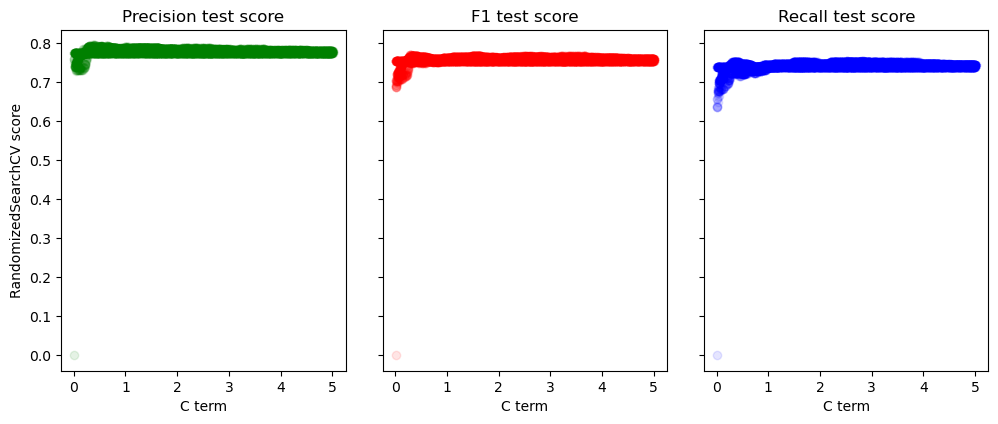

In [12]:
fig1, axes1= plt.subplots(figsize= (10,4), nrows= 1, ncols= 3, dpi= 100, sharey= True)
plt.tight_layout()
axes1[1].set_title('F1 test score')
axes1[1].set_xlabel('C term')
axes1[1].set_ylabel('')
axes1[1].scatter(pd.DataFrame(mod.cv_results_)['param_model__C'],
            pd.DataFrame(mod.cv_results_)['mean_test_f1'], color= 'red', alpha= 0.1)

axes1[0].set_title('Precision test score')
axes1[0].set_xlabel('C term')
axes1[0].set_ylabel('RandomizedSearchCV score')
axes1[0].scatter(pd.DataFrame(mod.cv_results_)['param_model__C'],
            pd.DataFrame(mod.cv_results_)['mean_test_precision'], color= 'green', alpha= 0.1)

axes1[2].set_title('Recall test score')
axes1[2].set_xlabel('C term')
axes1[2].set_ylabel('')
axes1[2].scatter(pd.DataFrame(mod.cv_results_)['param_model__C'],
            pd.DataFrame(mod.cv_results_)['mean_test_recall'], color= 'blue', alpha= 0.1)

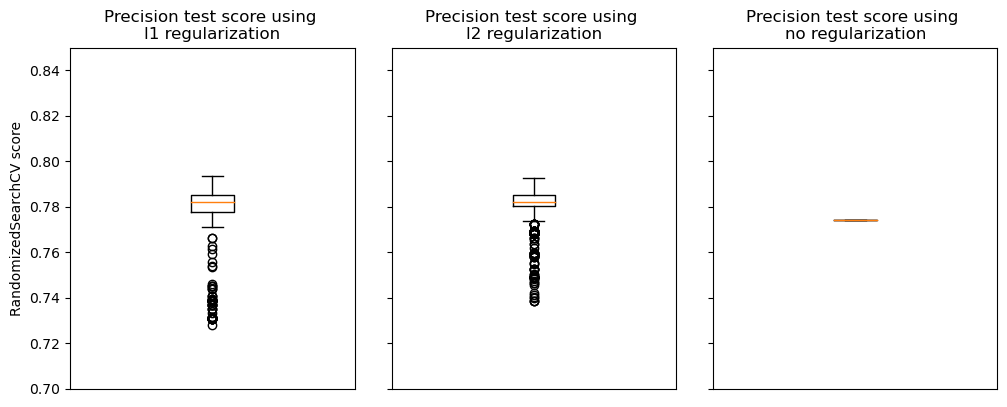

In [14]:
results= pd.DataFrame(mod.cv_results_)
results.sort_values(by= 'rank_test_precision', ascending= True).head()

l1= results[results['param_model__penalty'] == 'l1']['mean_test_precision']
l1= l1[~np.isnan(l1)]

l2= results[results['param_model__penalty'] == 'l2']['mean_test_precision']
l2= l2[~np.isnan(l2)]

none= results[results['param_model__penalty'] == 'none']['mean_test_precision']
none= none[~np.isnan(none)]

fig1, axes1= plt.subplots(figsize= (10,4), nrows= 1, ncols= 3, dpi= 100, sharey= True)
plt.tight_layout()
axes1[0].set_title('Precision test score using \nl1 regularization')
axes1[0].set_xlabel('')
axes1[0].set_ylabel('RandomizedSearchCV score')
axes1[0].boxplot(l1)
axes1[0].set_ylim(0.7,0.85)

axes1[1].set_title('Precision test score using \nl2 regularization')
axes1[1].set_xlabel('')
axes1[1].set_ylabel('')
axes1[1].boxplot(l2)

axes1[2].set_title('Precision test score using \nno regularization')
axes1[2].set_xlabel('')
axes1[2].set_ylabel('')
axes1[2].boxplot(none)

for ax in axes1:
    ax.set_xticks([])

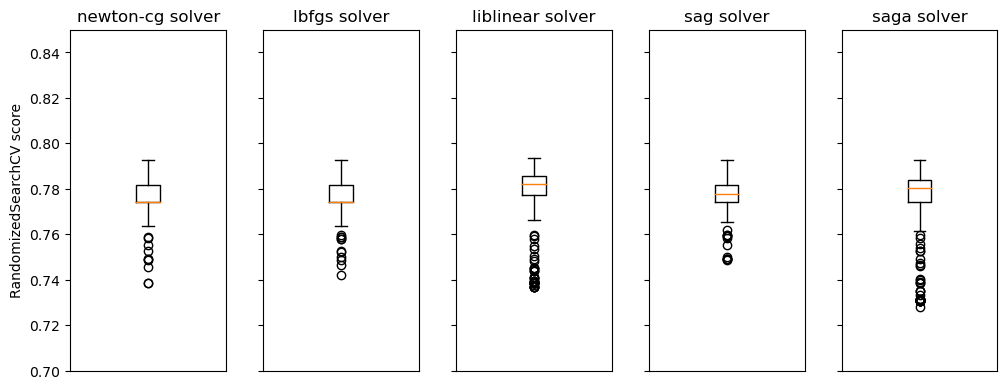

In [15]:
newton= results[results['param_model__solver'] == 'newton-cg']['mean_test_precision']
newton= newton[~np.isnan(newton)]

lbfgs= results[results['param_model__solver'] == 'lbfgs']['mean_test_precision']
lbfgs= lbfgs[~np.isnan(lbfgs)]

liblinear= results[results['param_model__solver'] == 'liblinear']['mean_test_precision']
liblinear= liblinear[~np.isnan(liblinear)]

sag= results[results['param_model__solver'] == 'sag']['mean_test_precision']
sag= sag[~np.isnan(sag)]

saga= results[results['param_model__solver'] == 'saga']['mean_test_precision']
saga= saga[~np.isnan(saga)]


fig1, axes1= plt.subplots(figsize= (10,4), nrows= 1, ncols= 5, dpi= 100, sharey= True)
plt.tight_layout()

axes1[0].set_title('newton-cg solver')
axes1[0].set_xlabel('')
axes1[0].set_ylabel('RandomizedSearchCV score')
axes1[0].boxplot(newton)

axes1[1].set_title('lbfgs solver')
axes1[1].boxplot(lbfgs)

axes1[2].set_title('liblinear solver')
axes1[2].boxplot(liblinear)
axes1[2].set_ylim(0.7,0.85)

axes1[3].set_title('sag solver')
axes1[3].boxplot(sag)

axes1[4].set_title('saga solver')
axes1[4].boxplot(saga)

    
for ax in axes1:
    ax.set_xticks([])

# Final prediction and metrics

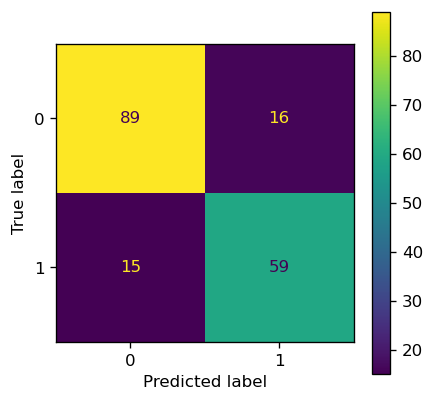

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test,y_pred=mod.best_estimator_.predict(X_test),))
fig, ax = plt.subplots(figsize=(4,4), dpi= 120)
disp.plot(ax=ax)